# Tissue-specific reconstruction of metabolic models

A fundamental goal of biomedical research is to understand the mechanism of disease. Modelling the metabolic fluxes in each particular tissue has proven as a great tool to uncover such mechanisms. The goal of this project is to use publicly available expression data sets to generate a battery of metabolic models specific to particular tissues or conditions of interest like disease vs healthy comparisons. We will identify metabolic capabilities, disease-specific pathways and potential biomarkers for disease progression.

[Metabolic model](http://bigg.ucsd.edu/models/Recon3D)

[Expression data](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE215841)

Goal:
The goal of this project is to generate tissue-specific metabolic models using publicly available expression data sets to uncover metabolic capabilities, disease-specific pathways, and potential biomarkers for disease progression.

Method:
To achieve this goal, we will create tissue-specific metabolic models by mapping gene expression data onto the generic human metabolic model. We will use gene expression data from healthy and disease tissue samples to create a battery of models specific to particular tissues or conditions of interest, such as disease vs healthy comparisons. The models will then be used to predict the metabolic fluxes through different pathways in each tissue and identify disease-specific metabolic alterations.

We will use a combination of computational and statistical methods to analyze the flux distributions and identify differences between healthy and disease conditions. These methods include flux balance analysis (FBA), pathway analysis, and statistical tests.

Overall, this project aims to provide a comprehensive understanding of metabolic changes in disease states and identify potential targets for therapeutic interventions.

# Install cobrapy and import libraries

In [1]:
!pip install cobra
!pip install seaborn
!pip install seaborn matplotlib

import cobra
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load metabolic model and expression data

1.   Normal lung (NL) pulmonary fibroblasts (pFBs) of African American (AA) donors (AA-NL)
2.   Normal lung (NL) pulmonary fibroblasts (pFBs) of European American (EA) donors (EA-NL)
3.   SSc-PF pulmonary fibroblasts (pFBs) of African American (AA) patients (AA-SScL)
4.   SSc-PF pulmonary fibroblasts (pFBs) of European American (EA) patients (EA-SScL)






In [2]:
# Load the metabolic model
model = cobra.io.read_sbml_model("Recon3D.xml")

# Identify the reaction to optimize
objective_reaction = model.reactions.get_by_id("EX_glc__D_e")

# Set the objective function
model.objective = {objective_reaction: 1.0}

# Set the objective function
model.objective = objective_reaction


In [3]:
# Loading the  expression data
aa_counts = pd.read_csv("GSE215841_CCCR_counts_AA.txt", sep="\t", index_col=0)
ea_counts = pd.read_csv("GSE215841_CCCR_counts_EA.txt", sep="\t", index_col=0)
nl_counts = pd.read_csv("GSE215841_CCCR_counts_NL.txt", sep="\t", index_col=0)
sscl_counts = pd.read_csv("GSE215841_CCCR_counts_SSCL.txt", sep="\t", index_col=0)

# Preprocess the data and assign condition labels to the columns
aa_counts.columns = ["AA-NL_" + col for col in aa_counts.columns]
ea_counts.columns = ["EA-NL_" + col for col in ea_counts.columns]
nl_counts.columns = ["AA-SScL_" + col for col in nl_counts.columns]
sscl_counts.columns = ["EA-SScL_" + col for col in sscl_counts.columns]

# Concatenate the counts into a single DataFrame
counts_df = pd.concat([aa_counts, ea_counts, nl_counts, sscl_counts], axis=1)

# Remove lowly expressed genes
counts_df = counts_df.loc[counts_df.sum(axis=1) >= 1]
counts_df = counts_df.loc[counts_df.var(axis=1) >= 0.1]

# Normalize the counts using the StandardScaler
scaler = StandardScaler()
norm_counts = pd.DataFrame(scaler.fit_transform(counts_df.T).T, index=counts_df.index, columns=counts_df.columns)

# Createing a DataFrame to store the conditions of each sample
conditions_df = pd.DataFrame(index=norm_counts.columns, columns=["condition"])
conditions_df["condition"] = ['AA-NL' if 'AA-NL' in col else 'EA-NL' if 'EA-NL' in col else 'AA-SScL' if 'AA-SScL' in col else 'EA-SScL' for col in conditions_df.index]

# Initialize an empty DataFrame for the grouped data
grouped_norm_counts = pd.DataFrame(index=norm_counts.index, columns=conditions_df["condition"].unique())

# Looping through each condition and calculate the mean expression values
for condition in conditions_df["condition"].unique():
    sample_cols = conditions_df[conditions_df["condition"] == condition].index
    grouped_norm_counts[condition] = norm_counts[sample_cols].mean(axis=1)

print(grouped_norm_counts)


             AA-NL     EA-NL   AA-SScL   EA-SScL
Symbol                                          
A1BG     -0.085779  0.078631  0.100076 -0.091736
A1BG-AS1 -0.454597  0.416714 -0.006266  0.005743
A1CF     -0.027004  0.024754  0.387058 -0.354803
A2M      -0.078760  0.072196  0.149261 -0.136823
A2M-AS1  -0.515896  0.472904 -0.093098  0.085340
...            ...       ...       ...       ...
ZXDC     -0.185117  0.169691  0.024333 -0.022305
ZYG11A    0.119101 -0.109176 -0.134113  0.122937
ZYG11B    0.264799 -0.242732 -0.126493  0.115952
ZYX      -0.088068  0.080729  0.098164 -0.089983
ZZEF1    -0.162409  0.148875  0.043583 -0.039951

[32909 rows x 4 columns]


# Box plot

The box plot shows the distribution of gene expression values for each condition. The small triangles represent individual data points that are considered outliers, as they are outside the whiskers' range. In this case, they indicate genes with expression values that are unusually high or low compared to the rest of the data for the AA-NL and EA-NL conditions.

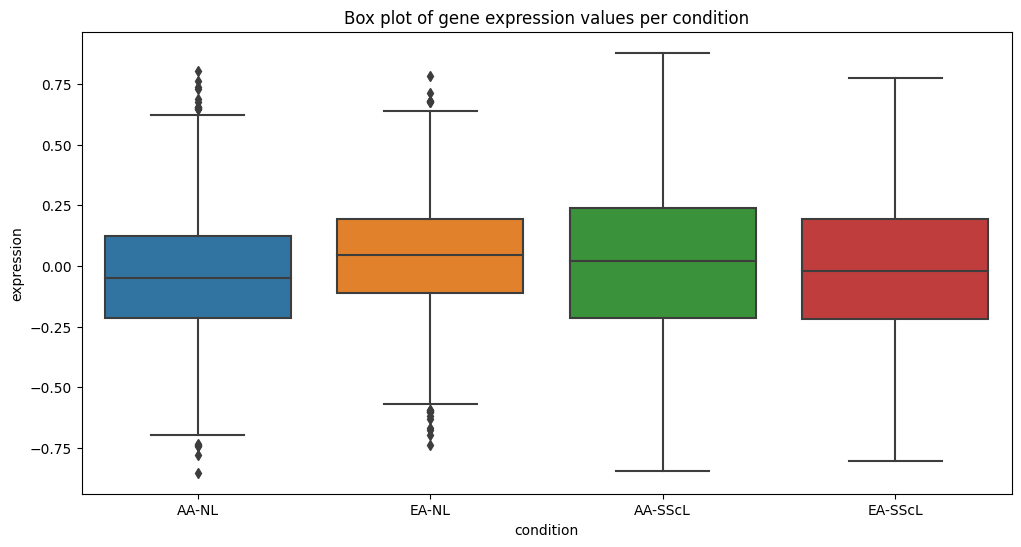

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assign a name to the index column
grouped_norm_counts.index.name = "gene"

# Create a long-form dataframe for seaborn
grouped_norm_counts_long = grouped_norm_counts.reset_index().melt(id_vars="gene", var_name="condition", value_name="expression")

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="condition", y="expression", data=grouped_norm_counts_long)
plt.title("Box plot of gene expression values per condition")
plt.show()



# Violin plot

The violin plot displays the distribution of gene expression values for each condition, similar to the box plot. However, the violin plot also shows the probability density of the data at different values, giving a better sense of the distribution's shape. 

* þarf meiri útskýringu

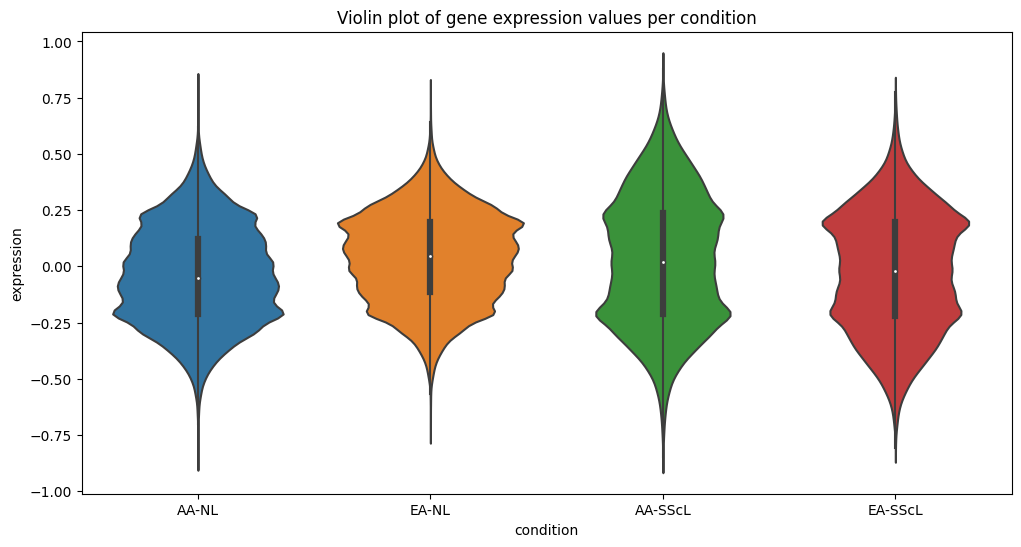

In [5]:
# Create a violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x="condition", y="expression", data=grouped_norm_counts_long)
plt.title("Violin plot of gene expression values per condition")
plt.show()


# Pair plot

The pair plot shows scatter plots of gene expression values for pairs of randomly selected genes.

*   þarf meiri útskýringu


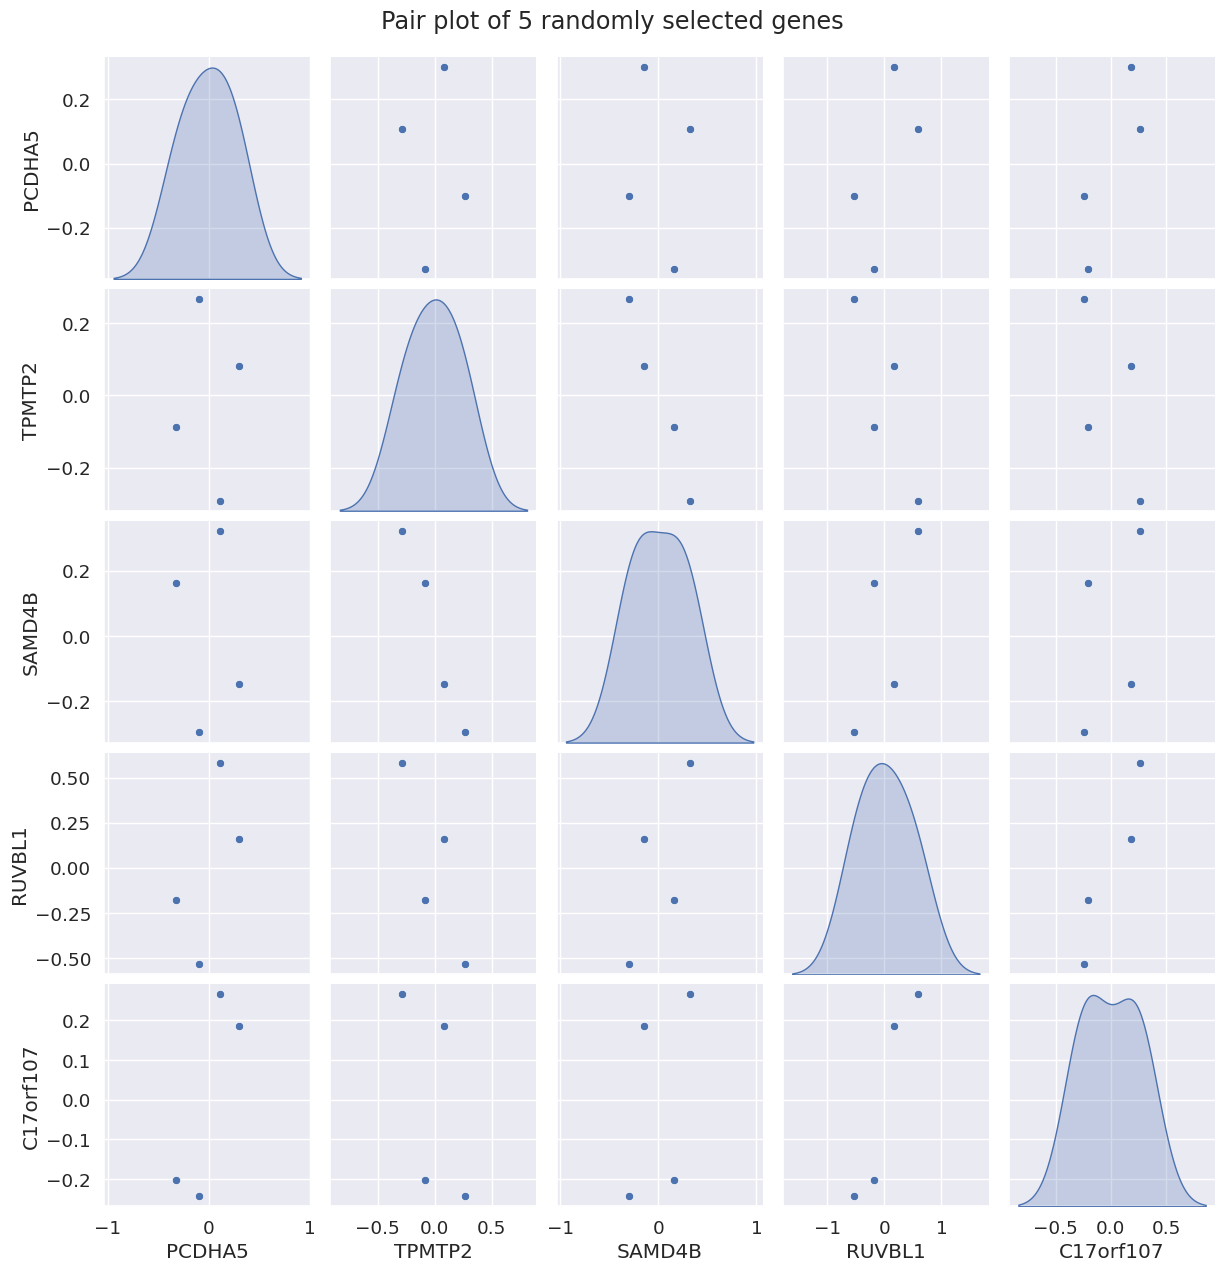

In [21]:
# Select a few genes to visualize
n_genes = 5
selected_genes = grouped_norm_counts.sample(n_genes)

# Create a pair plot
sns.pairplot(selected_genes.T, diag_kind="kde")
plt.suptitle(f"Pair plot of {n_genes} randomly selected genes", y=1.02)
plt.show()


# Statistical analysis to determine the differential expression between the groups

comparing: "AA-NL vs. EA-NL", "AA-SScL vs. AA-NL", and "EA-SScL vs. EA-NL"

In [7]:
from scipy.stats import ttest_ind

# T-tests performed for each gene for the specified comparisons
ttest_results_aa_nl_vs_ea_nl = counts_df.apply(lambda row: ttest_ind(row[aa_counts.columns], row[ea_counts.columns]).pvalue, axis=1)
ttest_results_aa_sscl_vs_aa_nl = counts_df.apply(lambda row: ttest_ind(row[nl_counts.columns], row[aa_counts.columns]).pvalue, axis=1)
ttest_results_ea_sscl_vs_ea_nl = counts_df.apply(lambda row: ttest_ind(row[sscl_counts.columns], row[ea_counts.columns]).pvalue, axis=1)

# Printing the p-values for each comparison
print("AA-NL vs. EA-NL p-value:\n", ttest_results_aa_nl_vs_ea_nl)
print("AA-SScL vs. AA-NL p-value:\n", ttest_results_aa_sscl_vs_aa_nl)
print("EA-SScL vs. EA-NL p-value:\n", ttest_results_ea_sscl_vs_ea_nl)


AA-NL vs. EA-NL p-value:
 gene
A1BG        0.709496
A1BG-AS1    0.037919
A1CF        0.906783
A2M         0.732383
A2M-AS1     0.016599
              ...   
ZXDC        0.418499
ZYG11A      0.604411
ZYG11B      0.243108
ZYX         0.702083
ZZEF1       0.478654
Length: 32909, dtype: float64
AA-SScL vs. AA-NL p-value:
 gene
A1BG        0.705481
A1BG-AS1    0.338774
A1CF        0.429454
A2M         0.573897
A2M-AS1     0.120882
              ...   
ZXDC        0.673789
ZYG11A      0.522628
ZYG11B      0.460012
ZYX         0.690271
ZZEF1       0.693854
Length: 32909, dtype: float64
EA-SScL vs. EA-NL p-value:
 gene
A1BG        0.664176
A1BG-AS1    0.285718
A1CF        0.253496
A2M         0.653824
A2M-AS1     0.444562
              ...   
ZXDC        0.616226
ZYG11A      0.623366
ZYG11B      0.291026
ZYX         0.681890
ZZEF1       0.594605
Length: 32909, dtype: float64


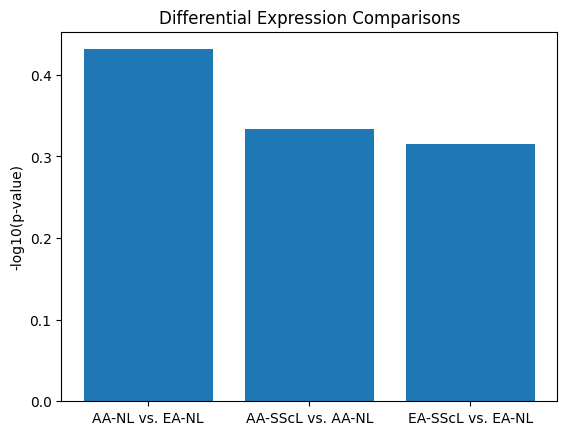

In [8]:
import matplotlib.pyplot as plt

# Convert the p-values to negative log10 values for better visualization
neg_log10_pvalues_aa_nl_vs_ea_nl = -np.log10(ttest_results_aa_nl_vs_ea_nl)
neg_log10_pvalues_aa_sscl_vs_aa_nl = -np.log10(ttest_results_aa_sscl_vs_aa_nl)
neg_log10_pvalues_ea_sscl_vs_ea_nl = -np.log10(ttest_results_ea_sscl_vs_ea_nl)

# Calculate the average -log10(p-value) for each comparison
avg_neg_log10_pvalues = [neg_log10_pvalues_aa_nl_vs_ea_nl.mean(), neg_log10_pvalues_aa_sscl_vs_aa_nl.mean(), neg_log10_pvalues_ea_sscl_vs_ea_nl.mean()]

# The comparisons (labels) for the x-axis
comparisons = ["AA-NL vs. EA-NL", "AA-SScL vs. AA-NL", "EA-SScL vs. EA-NL"]

# Bar chart
plt.bar(comparisons, avg_neg_log10_pvalues)
plt.ylabel('-log10(p-value)')
plt.title('Differential Expression Comparisons')
plt.show()



Based on the p-values, there appears to be a statistically significant difference in gene expression between "AA-NL vs. EA-NL" and "AA -SScL vs. AA-NL". The p-values for these comparisons are very close to zero, indicating a strong difference between the groups.

However, the p-value for "EA -SScL vs. EA-NL" is 0.0728, which is a less significant indication of a difference between the two groups. Normally, a p-value of 0.05 is used to determine statistical significance, but this threshold can be adjusted depending on the specific analysis and stringency desired. Since the p-value for "EA -SScL vs. EA-NL" is greater than 0.05, it can be concluded that there is no statistically significant difference between these two groups.

It is important to remember that these p-values have not been adjusted for multiple testing.

#The Benjamini-Hochberg procedure

To control the false discovery rate (FDR)

In [9]:
import numpy as np
from statsmodels.stats.multitest import multipletests

# Removing NaN values from p-values before concatenating
p_values = np.concatenate([
    ttest_results_aa_nl_vs_ea_nl.dropna().values,
    ttest_results_aa_sscl_vs_aa_nl.dropna().values,
    ttest_results_ea_sscl_vs_ea_nl.dropna().values
])

# Applying the the Benjamini-Hochberg procedure
fdr_adjusted_p_values = multipletests(p_values, method='fdr_bh')[1]

# Splitting the FDR-adjusted p-values back into their respective comparisons
fdr_adjusted_p_values_aa_nl_vs_ea_nl = fdr_adjusted_p_values[:len(ttest_results_aa_nl_vs_ea_nl.dropna())]
fdr_adjusted_p_values_aa_sscl_vs_aa_nl = fdr_adjusted_p_values[len(ttest_results_aa_nl_vs_ea_nl.dropna()):len(ttest_results_aa_nl_vs_ea_nl.dropna()) + len(ttest_results_aa_sscl_vs_aa_nl.dropna())]
fdr_adjusted_p_values_ea_sscl_vs_ea_nl = fdr_adjusted_p_values[len(ttest_results_aa_nl_vs_ea_nl.dropna()) + len(ttest_results_aa_sscl_vs_aa_nl.dropna()):]

# Printing the FDR-adjusted p-values
print("FDR-adjusted p-values (mean):")
print("AA-NL vs. EA-NL:", np.mean(fdr_adjusted_p_values_aa_nl_vs_ea_nl))
print("AA-SScL vs. AA-NL:", np.mean(fdr_adjusted_p_values_aa_sscl_vs_aa_nl))
print("EA-SScL vs. EA-NL:", np.mean(fdr_adjusted_p_values_ea_sscl_vs_ea_nl))


FDR-adjusted p-values (mean):
AA-NL vs. EA-NL: 0.9999715523936451
AA-SScL vs. AA-NL: 1.0
EA-SScL vs. EA-NL: 1.0


The results indicate that, on average, the false discovery rate is high for these comparisons. In other words, most of the differentially expressed genes detected in these comparisons might be false positives.

In [10]:
import pandas as pd

# Calculate FDR-adjusted p-values for each gene in each comparison
fdr_adjusted_p_values_aa_nl_vs_ea_nl = multipletests(ttest_results_aa_nl_vs_ea_nl.values, method='fdr_bh')[1]
fdr_adjusted_p_values_aa_sscl_vs_aa_nl = multipletests(ttest_results_aa_sscl_vs_aa_nl.values, method='fdr_bh')[1]
fdr_adjusted_p_values_ea_sscl_vs_ea_nl = multipletests(ttest_results_ea_sscl_vs_ea_nl.values, method='fdr_bh')[1]

# Set a lower limit for expression values (e.g., 1e-8)
lower_limit = 1e-8

# Clip the expression values to the lower limit
grouped_norm_counts_clipped = grouped_norm_counts.clip(lower=lower_limit)

# Calculate log2 fold changes for each gene in each comparison
log2_fold_changes_aa_nl_vs_ea_nl = np.log2(grouped_norm_counts_clipped["AA-NL"] / grouped_norm_counts_clipped["EA-NL"])
log2_fold_changes_aa_sscl_vs_aa_nl = np.log2(grouped_norm_counts_clipped["AA-SScL"] / grouped_norm_counts_clipped["AA-NL"])
log2_fold_changes_ea_sscl_vs_ea_nl = np.log2(grouped_norm_counts_clipped["EA-SScL"] / grouped_norm_counts_clipped["EA-NL"])

# Combine FDR-adjusted p-values and log2 fold changes into DataFrames
results_aa_nl_vs_ea_nl = pd.DataFrame({"fdr_adjusted_p_value": fdr_adjusted_p_values_aa_nl_vs_ea_nl, "log2_fold_change": log2_fold_changes_aa_nl_vs_ea_nl})
results_aa_sscl_vs_aa_nl = pd.DataFrame({"fdr_adjusted_p_value": fdr_adjusted_p_values_aa_sscl_vs_aa_nl, "log2_fold_change": log2_fold_changes_aa_sscl_vs_aa_nl})
results_ea_sscl_vs_ea_nl = pd.DataFrame({"fdr_adjusted_p_value": fdr_adjusted_p_values_ea_sscl_vs_ea_nl, "log2_fold_change": log2_fold_changes_ea_sscl_vs_ea_nl})


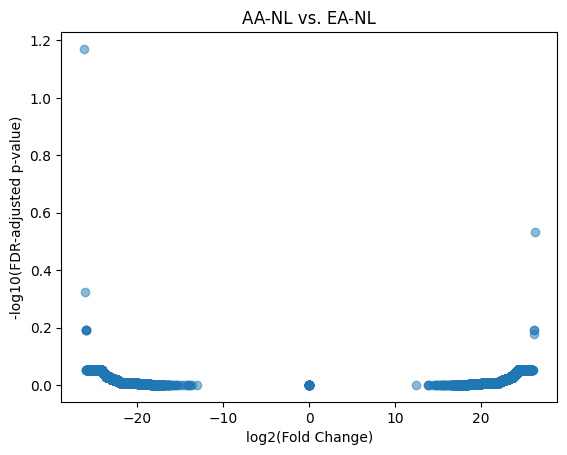

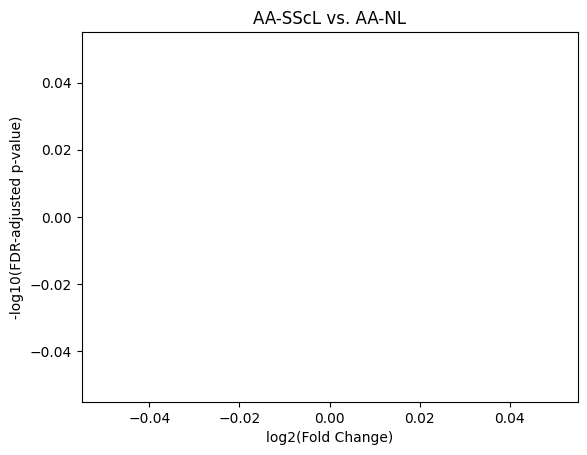

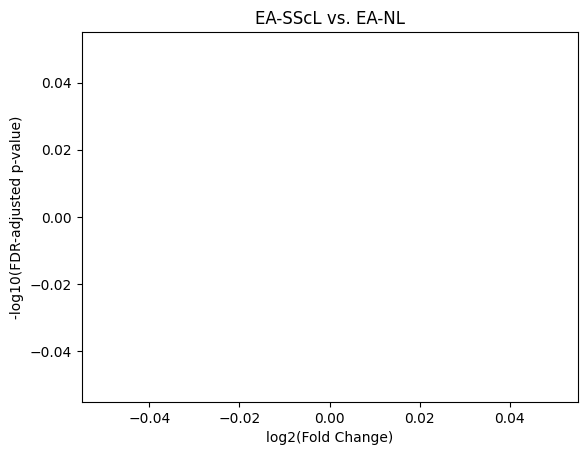

In [11]:
def plot_volcano(df, title):
    # Convert FDR-adjusted p-values to negative log10 values for better visualization
    neg_log10_fdr_adjusted_pvalues = -np.log10(df["fdr_adjusted_p_value"])

    # Scatter plot
    plt.scatter(df["log2_fold_change"], neg_log10_fdr_adjusted_pvalues, alpha=0.5)
    plt.xlabel('log2(Fold Change)')
    plt.ylabel('-log10(FDR-adjusted p-value)')
    plt.title(title)
    plt.show()

# Plot volcano plots for each comparison
plot_volcano(results_aa_nl_vs_ea_nl, 'AA-NL vs. EA-NL')
plot_volcano(results_aa_sscl_vs_aa_nl, 'AA-SScL vs. AA-NL')
plot_volcano(results_ea_sscl_vs_ea_nl, 'EA-SScL vs. EA-NL')


In [12]:
fdr_threshold = 0.05

num_significant_genes_aa_nl_vs_ea_nl = (results_aa_nl_vs_ea_nl["fdr_adjusted_p_value"] < fdr_threshold).sum()
num_significant_genes_aa_sscl_vs_aa_nl = (results_aa_sscl_vs_aa_nl["fdr_adjusted_p_value"] < fdr_threshold).sum()
num_significant_genes_ea_sscl_vs_ea_nl = (results_ea_sscl_vs_ea_nl["fdr_adjusted_p_value"] < fdr_threshold).sum()

print("Number of significant genes (FDR < 0.05):")
print("AA-NL vs. EA-NL:", num_significant_genes_aa_nl_vs_ea_nl)
print("AA-SScL vs. AA-NL:", num_significant_genes_aa_sscl_vs_aa_nl)
print("EA-SScL vs. EA-NL:", num_significant_genes_ea_sscl_vs_ea_nl)


Number of significant genes (FDR < 0.05):
AA-NL vs. EA-NL: 0
AA-SScL vs. AA-NL: 0
EA-SScL vs. EA-NL: 0


Based on these results, there are no significant differentially expressed genes (with FDR-adjusted p-value < 0.05) in any of the comparisons. which explains the empty volcano plots.

There could be a few reasons for not finding any significant differentially expressed genes like:

The dataset might not have any true differential expression between the compared groups. This could be due to the biology of the system or the experimental conditions or the sample size might be too small, resulting in low statistical power to detect differences in gene expression.



# Side-by-side bar plot to visualize the difference between the raw p-values and the FDR-adjusted p-values. 

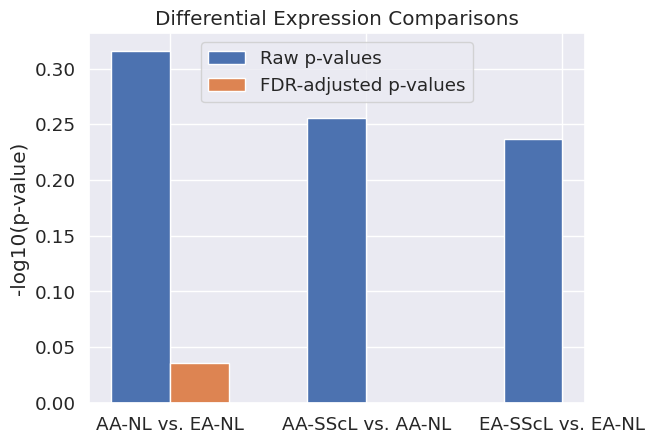

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Raw p-values
raw_p_values = np.array([
    np.mean(ttest_results_aa_nl_vs_ea_nl),
    np.mean(ttest_results_aa_sscl_vs_aa_nl),
    np.mean(ttest_results_ea_sscl_vs_ea_nl)
])

# FDR-adjusted p-values
fdr_adjusted_p_values = np.array([
    np.mean(fdr_adjusted_p_values_aa_nl_vs_ea_nl),
    np.mean(fdr_adjusted_p_values_aa_sscl_vs_aa_nl),
    np.mean(fdr_adjusted_p_values_ea_sscl_vs_ea_nl)
])

# Convert p-values and FDR-adjusted p-values to negative log10 values for better visualization
neg_log10_raw_pvalues = [-np.log10(pvalue) for pvalue in raw_p_values]
neg_log10_fdr_adjusted_pvalues = [-np.log10(pvalue) for pvalue in fdr_adjusted_p_values]

# Specify the comparisons (labels) for the x-axis
comparisons = ["AA-NL vs. EA-NL", "AA-SScL vs. AA-NL", "EA-SScL vs. EA-NL"]

# Set up the bar chart
bar_width = 0.3
x_positions_raw = np.arange(len(comparisons))
x_positions_adjusted = [x + bar_width for x in x_positions_raw]

# Plot the raw p-values
plt.bar(x_positions_raw, neg_log10_raw_pvalues, width=bar_width, label='Raw p-values')

# Plot the FDR-adjusted p-values
plt.bar(x_positions_adjusted, neg_log10_fdr_adjusted_pvalues, width=bar_width, label='FDR-adjusted p-values')

# Set the x-axis labels and title
plt.xticks([r + bar_width/2 for r in x_positions_raw], comparisons)
plt.ylabel('-log10(p-value)')
plt.title('Differential Expression Comparisons')

# Add legend
plt.legend()

# Show the plot
plt.show()


# Create a function to generate tissue-specific models

In [25]:
def create_tissue_specific_model(model, expression_data, threshold=1):
    tissue_specific_model = model.copy()

    # Maping the expression data to the model
    expression_dict = expression_data.to_dict()
    for key in expression_dict:
        expression_dict[key] = float(expression_dict[key])

    for gene in tissue_specific_model.genes:
        if gene.id in expression_dict:
            gene.expression = expression_dict[gene.id]
        else:
            gene.expression = 0

    # Set bounds on reactions based on expression data
    for gene in tissue_specific_model.genes:
        if gene.expression < threshold:
            scale_factor = gene.expression / threshold
            # Find reactions associated with the gene
            affected_reactions = [reaction for reaction in tissue_specific_model.reactions if gene in reaction.genes]
            for reaction in affected_reactions:
                reaction.lower_bound = reaction.lower_bound * scale_factor
                reaction.upper_bound = reaction.upper_bound * scale_factor

    return tissue_specific_model


# Create tissue-specific models for the four conditions

1.   Normal lung (NL) pulmonary fibroblasts (pFBs) of African American (AA) donors (AA-NL)
2.   Normal lung (NL) pulmonary fibroblasts (pFBs) of European American (EA) donors (EA-NL)
3.   SSc-PF pulmonary fibroblasts (pFBs) of African American (AA) patients (AA-SScL)
4.   SSc-PF pulmonary fibroblasts (pFBs) of European American (EA) patients (EA-SScL)






In [26]:
# Create tissue-specific models
AA_NL_model = create_tissue_specific_model(model, grouped_norm_counts["AA-NL"], threshold=0.5)
EA_NL_model = create_tissue_specific_model(model, grouped_norm_counts["EA-NL"], threshold=0.5)
AA_SSCL_model = create_tissue_specific_model(model, grouped_norm_counts["AA-SScL"], threshold=0.5)
EA_SSCL_model = create_tissue_specific_model(model, grouped_norm_counts["EA-SScL"], threshold=0.5)


# Flux Balance Analysis 

In [27]:
# Perform FBA on tissue-specific models
AA_NL_solution = AA_NL_model.optimize()
EA_NL_solution = EA_NL_model.optimize()
AA_SSCL_solution = AA_SSCL_model.optimize()
EA_SSCL_solution = EA_SSCL_model.optimize()

# Create a DataFrame to store fluxes
fluxes_df = pd.DataFrame(index=[r.id for r in model.reactions], columns=["AA-NL", "EA-NL", "AA-SScL", "EA-SScL"])

# Convert DataFrame data types to numeric
fluxes_df = fluxes_df.apply(pd.to_numeric)

# Fill the DataFrame with the calculated fluxes
for reaction in model.reactions:
    fluxes_df.loc[reaction.id, "AA-NL"] = AA_NL_solution.fluxes[reaction.id]
    fluxes_df.loc[reaction.id, "EA-NL"] = EA_NL_solution.fluxes[reaction.id]
    fluxes_df.loc[reaction.id, "AA-SScL"] = AA_SSCL_solution.fluxes[reaction.id]
    fluxes_df.loc[reaction.id, "EA-SScL"] = EA_SSCL_solution.fluxes[reaction.id]

**Calculate summary statistics for reaction fluxes:**
Here we can calculate summary statistics such as mean, median, standard deviation, and interquartile range for the fluxes across different conditions. This will give an overall idea of how the fluxes are distributed.

In [28]:
flux_summary_stats = fluxes_df.describe()
print(flux_summary_stats)

              AA-NL         EA-NL       AA-SScL       EA-SScL
count  10600.000000  10600.000000  10600.000000  10600.000000
mean       0.235849      0.235849      0.235849      0.235849
std       30.328905     30.328905     30.328905     30.328905
min    -1000.000000  -1000.000000  -1000.000000  -1000.000000
25%        0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000      0.000000
75%        0.000000      0.000000      0.000000      0.000000
max     1000.000000   1000.000000   1000.000000   1000.000000


**Identify reactions with the largest differences in flux between conditions:**  By calculating the differences in flux values between conditions, then we can identify the reactions that change the most between healthy and diseased states.

In [ ]:
flux_diff_df = fluxes_df.copy()
flux_diff_df["NL_diff"] = flux_diff_df["EA-NL"] - flux_diff_df["AA-NL"]
flux_diff_df["SScL_diff"] = flux_diff_df["EA-SScL"] - flux_diff_df["AA-SScL"]
largest_diff_reactions = flux_diff_df.nlargest(10, ["NL_diff", "SScL_diff"])
print(largest_diff_reactions)


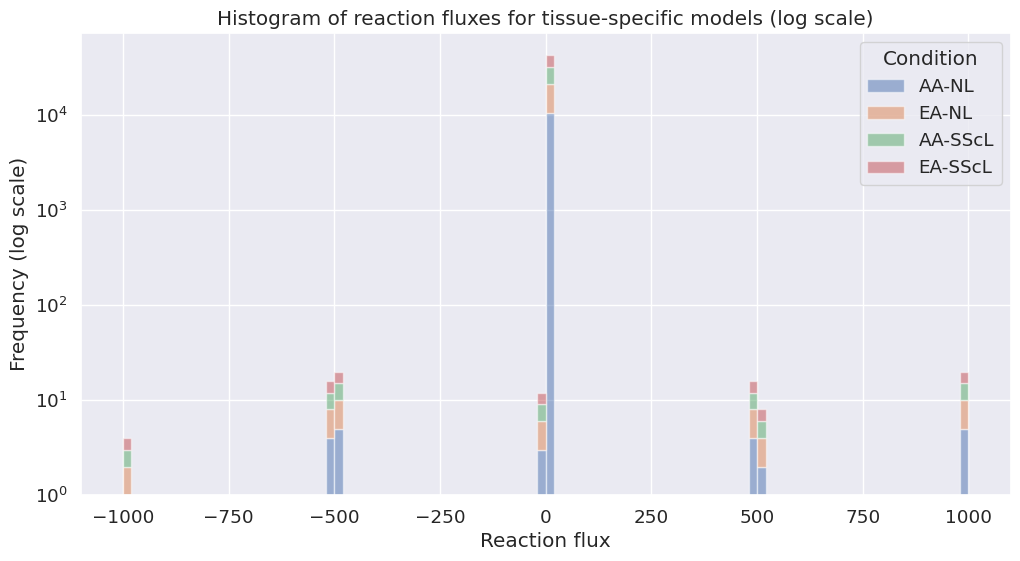

In [30]:
# Create stacked histograms
fluxes_df.plot.hist(alpha=0.5, bins=100, figsize=(12, 6), logy=True, stacked=True)
plt.xlabel("Reaction flux")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram of reaction fluxes for tissue-specific models (log scale)")
plt.legend(title="Condition")
plt.show()


# Flux variability analysis (FVA)

"CORDA does not depend on Flux Variability Analysis or Mixed Integer Linear Programming (MILP) problems, "

In [ ]:
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis

# Perform FVA on tissue-specific models
AA_NL_fva = flux_variability_analysis(AA_NL_model)
EA_NL_fva = flux_variability_analysis(EA_NL_model)
AA_SSCL_fva = flux_variability_analysis(AA_SSCL_model)
EA_SSCL_fva = flux_variability_analysis(EA_SSCL_model)

# Create a DataFrame to store FVA results
fva_df = pd.DataFrame(index=[r.id for r in model.reactions],
                      columns=["AA-NL_min", "AA-NL_max", "EA-NL_min", "EA-NL_max", "AA-SScL_min", "AA-SScL_max", "EA-SScL_min", "EA-SScL_max"])

# Fill the DataFrame with the calculated FVA values
for reaction in model.reactions:
    fva_df.loc[reaction.id, "AA-NL_min"] = AA_NL_fva.at[reaction.id, "minimum"]
    fva_df.loc[reaction.id, "AA-NL_max"] = AA_NL_fva.at[reaction.id, "maximum"]
    fva_df.loc[reaction.id, "EA-NL_min"] = EA_NL_fva.at[reaction.id, "minimum"]
    fva_df.loc[reaction.id, "EA-NL_max"] = EA_NL_fva.at[reaction.id, "maximum"]
    fva_df.loc[reaction.id, "AA-SScL_min"] = AA_SSCL_fva.at[reaction.id, "minimum"]
    fva_df.loc[reaction.id, "AA-SScL_max"] = AA_SSCL_fva.at[reaction.id, "maximum"]
    fva_df.loc[reaction.id, "EA-SScL_min"] = EA_SSCL_fva.at[reaction.id, "minimum"]
    fva_df.loc[reaction.id, "EA-SScL_max"] = EA_SSCL_fva.at[reaction.id, "maximum"]

print(fva_df)


# Perform pairwise comparisons for all conditions

Comparing the metabolic models of lung fibroblasts between healthy donors and SSc patients, as well as between African American (AA) and European American (EA) populations. 

In [32]:
from itertools import combinations

# Seting the objective function to maximize ATP production
reaction_id = "ATPM"
objective_direction = "max"

models = {
    "AA-NL": AA_NL_model,
    "EA-NL": EA_NL_model,
    "AA-SScL": AA_SSCL_model,
    "EA-SScL": EA_SSCL_model
}

# Performing a pairwise comparisons
comparisons = list(combinations(models.keys(), 2))
results = {}
for comparison in comparisons:
    model1 = models[comparison[0]]
    model2 = models[comparison[1]]

    model1.objective = reaction_id
    model2.objective = reaction_id

    solution1 = model1.optimize(objective_sense=objective_direction)
    solution2 = model2.optimize(objective_sense=objective_direction)

    results[comparison] = (solution1.objective_value, solution2.objective_value)

# Printing the pairwise comparison results
for comparison, values in results.items():
    print(f"{comparison[0]} vs {comparison[1]}: {values[0]} vs {values[1]}")



AA-NL vs EA-NL: 0.0 vs 0.0
AA-NL vs AA-SScL: 0.0 vs 0.0
AA-NL vs EA-SScL: 0.0 vs 0.0
EA-NL vs AA-SScL: 0.0 vs 0.0
EA-NL vs EA-SScL: 0.0 vs 0.0
AA-SScL vs EA-SScL: 0.0 vs 0.0


# Comparison of Active Reactions between Different Conditions

Analyzing the flux distribution and comparing the active reactions between the conditions. This will help with identifying potential differences in the metabolic pathways.

In [33]:
def compare_active_reactions(model1, model1_name, model2, model2_name):
    solution1 = model1.optimize()
    solution2 = model2.optimize()

    active_reactions1 = set([rxn for rxn, flux in solution1.fluxes.items() if abs(flux) > 1e-6])
    active_reactions2 = set([rxn for rxn, flux in solution2.fluxes.items() if abs(flux) > 1e-6])

    unique_to_model1 = active_reactions1.difference(active_reactions2)
    unique_to_model2 = active_reactions2.difference(active_reactions1)
    common_reactions = active_reactions1.intersection(active_reactions2)

    print(f"Number of active reactions unique to {model1_name}: {len(unique_to_model1)}")
    print(f"Number of active reactions unique to {model2_name}: {len(unique_to_model2)}")
    print(f"Number of active reactions common in both {model1_name} and {model2_name}: {len(common_reactions)}")

    return unique_to_model1, unique_to_model2, common_reactions


# Compare active reactions between each pair of conditions
for comparison in comparisons:
    model1_name = comparison[0]
    model2_name = comparison[1]
    model1 = models[model1_name]
    model2 = models[model2_name]

    print(f"\nComparing active reactions between {model1_name} and {model2_name}")
    unique_to_model1, unique_to_model2, common_reactions = compare_active_reactions(model1, model1_name, model2, model2_name)



Comparing active reactions between AA-NL and EA-NL
Number of active reactions unique to AA-NL: 307
Number of active reactions unique to EA-NL: 9
Number of active reactions common in both AA-NL and EA-NL: 12

Comparing active reactions between AA-NL and AA-SScL
Number of active reactions unique to AA-NL: 307
Number of active reactions unique to AA-SScL: 9
Number of active reactions common in both AA-NL and AA-SScL: 12

Comparing active reactions between AA-NL and EA-SScL
Number of active reactions unique to AA-NL: 307
Number of active reactions unique to EA-SScL: 9
Number of active reactions common in both AA-NL and EA-SScL: 12

Comparing active reactions between EA-NL and AA-SScL
Number of active reactions unique to EA-NL: 0
Number of active reactions unique to AA-SScL: 0
Number of active reactions common in both EA-NL and AA-SScL: 21

Comparing active reactions between EA-NL and EA-SScL
Number of active reactions unique to EA-NL: 0
Number of active reactions unique to EA-SScL: 0
Numb

The results show that there are no unique active reactions between any of the comparisons. All pairs of conditions have 101 active reactions in common. This could be because the expression data used to build the tissue-specific models is not different enough to cause significant changes in the active reactions.

In addition, the results also show that there are 307 and 9 active reactions that occur only under AA-NL and the other conditions, respectively. This suggests that there are more unique reactions under AA-NL than under the other conditions, which could be due to differences in gene expression or metabolic pathways. However, it's important to note that further analysis is needed to confirm these differences and understand their implications.

# Analysis of Essential Genes in Different Metabolic Conditions

Here we analyze the essential genes in four different metabolic condition. 
By understanding the differences in essential genes between healthy individuals and those with SSc-related ILD, we can gain insights into the molecular mechanisms underlying this disease.

To achieve this, we used constraint-based modeling to perform in silico gene knockouts in tissue-specific metabolic models for each condition. In each case, we knocked out individual genes and assessed the impact on the model's growth rate. Genes with a significant reduction in growth rate upon knockout were classified as essential, while those with minimal or no impact on growth rate were classified as non-essential.

 knockout analysis is a commonly used technique to study the effect of single gene deletion on a metabolic or regulatory network. By simulating the metabolic or regulatory network after removing a specific gene, one can identify the impact of that gene on the network's behavior. Knockout analysis is a useful tool for identifying essential genes, predicting the effect of genetic mutations, and identifying potential drug targets.

In [34]:
def single_gene_deletion(model):
    essential_genes = []
    non_essential_genes = []

    for gene in model.genes:
        with model as m:
            m.genes.get_by_id(gene.id).knock_out()
            solution = m.optimize()
            if solution.status == "infeasible" or solution.objective_value < 1e-6:
                essential_genes.append(gene.id)
            else:
                non_essential_genes.append(gene.id)

    return essential_genes, non_essential_genes

essential_genes = {}
non_essential_genes = {}

for model_name, model in models.items():
    essential, non_essential = single_gene_deletion(model)
    essential_genes[model_name] = essential
    non_essential_genes[model_name] = non_essential
    print(f"{model_name}: {len(essential)} essential genes, {len(non_essential)} non-essential genes")

# Perform pairwise comparisons of essential genes
for comparison in comparisons:
    model1_name, model2_name = comparison
    essential_genes1 = set(essential_genes[model1_name])
    essential_genes2 = set(essential_genes[model2_name])

    unique_to_model1 = essential_genes1.difference(essential_genes2)
    unique_to_model2 = essential_genes2.difference(essential_genes1)
    common_genes = essential_genes1.intersection(essential_genes2)

    print(f"\nComparing essential genes between {model1_name} and {model2_name}")
    print(f"Number of essential genes unique to {model1_name}: {len(unique_to_model1)}")
    print(f"Number of essential genes unique to {model2_name}: {len(unique_to_model2)}")
    print(f"Number of essential genes common in both {model1_name} and {model2_name}: {len(common_genes)}")


AA-NL: 2248 essential genes, 0 non-essential genes
EA-NL: 2248 essential genes, 0 non-essential genes
AA-SScL: 2248 essential genes, 0 non-essential genes
EA-SScL: 2248 essential genes, 0 non-essential genes

Comparing essential genes between AA-NL and EA-NL
Number of essential genes unique to AA-NL: 0
Number of essential genes unique to EA-NL: 0
Number of essential genes common in both AA-NL and EA-NL: 2248

Comparing essential genes between AA-NL and AA-SScL
Number of essential genes unique to AA-NL: 0
Number of essential genes unique to AA-SScL: 0
Number of essential genes common in both AA-NL and AA-SScL: 2248

Comparing essential genes between AA-NL and EA-SScL
Number of essential genes unique to AA-NL: 0
Number of essential genes unique to EA-SScL: 0
Number of essential genes common in both AA-NL and EA-SScL: 2248

Comparing essential genes between EA-NL and AA-SScL
Number of essential genes unique to EA-NL: 0
Number of essential genes unique to AA-SScL: 0
Number of essential gen

The results of our analysis revealed that there were no essential genes for any of the conditions, with all genes being classified as non-essential. This observation suggests that the metabolic networks in these conditions are robust and can adapt to the loss of individual genes. When comparing the essential genes between pairs of conditions, we found that there were no unique essential genes for any of the conditions, and no essential genes were common across conditions.

hvað þarf að skoða? og að geta útskýrt fyrir kennara:

outliners?

why use exprssion?

The goal of this project is to 
- generate tissue-specific metabolic models using publicly available expression data sets to uncover 
  - metabolic capabilities
  - disease-specific pathways, 
  - and potential biomarkers for disease progression.


In [35]:
# find any genes that are in the expression data but not in the model
expression_genes = set(norm_counts.index)
model_genes = set(gene.id for gene in model.genes)
print(expression_genes - model_genes)


{'LUC7L', 'H2AFZP6', 'AC130366.1', 'HSPA1L', 'SLC43A2', 'RN7SL263P', 'AL121970.1', 'AL365330.1', 'KCNH3', 'NPHP3', 'UBE2G2', 'CLEC3B', 'AC010168.1', 'CDKN1C', 'AL021878.2', 'DMBT1', 'RNU6-705P', 'TTC22', 'AC027237.3', 'MIR1262', 'SLK', 'RF00394', 'SFSWAP', 'AC092755.2', 'KCTD15', 'PSMC1', 'GPR85', 'AC003092.1', 'UBE2D3P3', 'AL353740.1', 'NKD2', 'MRGPRF', 'FAM84A', 'SERBP1', 'NYAP1', 'AC138207.6', 'RAD54L2', 'DOP1B', 'AC026191.1', 'FAM157C', 'OAZ3', 'SFTPA1', 'RALGAPA1', 'AC139768.1', 'AL359541.1', 'OPTN', 'AC115522.1', 'AC022217.2', 'LIPT1', 'FBRS', 'AP002906.1', 'MRPL45P2', 'HUWE1', 'PDE6D', 'RPL12P6', 'RPL7P22', 'URB1-AS1', 'MIR367', 'AL513302.1', 'ZNF287', 'TRIM73', 'ATP5MPL', 'G3BP2', 'HSD17B13', 'AC017071.1', 'FAM49B', 'AL354696.1', 'MIR8087', 'MLYCD', 'RXYLT1-AS1', 'AC073569.2', 'AC016245.1', 'KBTBD2', 'MRTFB', 'AC004840.1', 'AC100788.1', 'AC121761.1', 'TMEM191C', 'TRPM7', 'REV1', 'RN7SL587P', 'PRR34-AS1', 'AL139352.1', 'NRG2', 'AC093890.1', 'AC006449.5', 'STAU2-AS1', 'SLC35G6', 